# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

### Wprowadzanie wielokątów

<IPython.core.display.Javascript object>


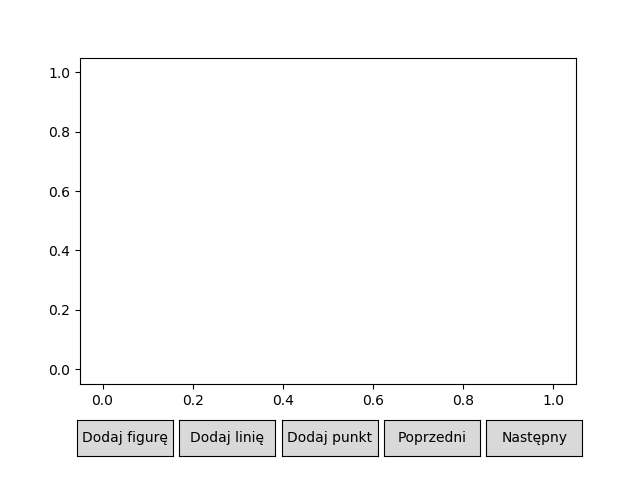

In [3]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


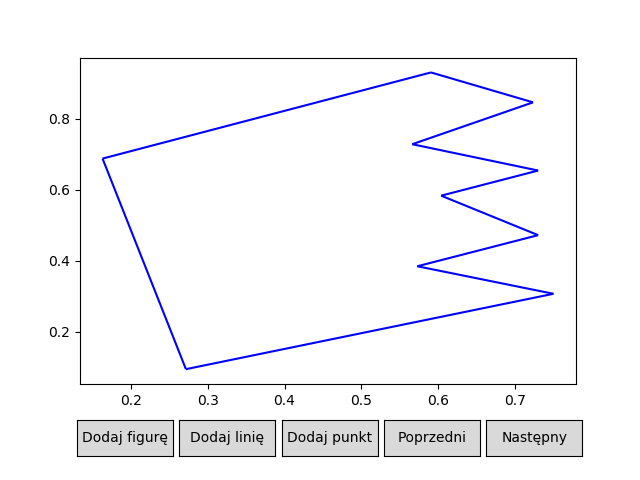

In [4]:
plot2 = Plot([plot1.get_added_elements()])
    
data = js.loads(plot2.toJson())
polygons = []

for lines in data[0]["lines"]:
    if lines:
        polygon = [lines[0][0]]
        for line in lines:
            polygon.append(line[1])
        polygons.append(polygon)
        
scenes = [Scene([PointsCollection([])])]
if polygons:
    scenes = [Scene([PointsCollection([])], 
                    [LinesCollection([[polygons[i][j], polygons[i][j + 1]] for j in range(len(polygons[i]) - 1)], 
                                     color = 'blue')]) for i in range(len(polygons))]

######### Ewentualny zapis do pliku ##########################################################
# with open('polygons.json', 'w') as file:
#     file.write(Plot(scenes).toJson())
###############################################################################################

######### Ewentualne odczytanie z pliku ######################################################
with open('polygons.json', 'r') as file:
    data = file.read()
data = js.loads(data)
polygons = []

for i in range(len(data)):
    for lines in data[i]["lines"]:
        if lines:
            polygon = [lines[0][0]]
            for line in lines:
                polygon.append(line[1])
            polygons.append(polygon)

if polygons:
    scenes = [Scene([PointsCollection([])], 
                    [LinesCollection([[polygons[i][j], polygons[i][j + 1]] for j in range(len(polygons[i]) - 1)], 
                                     color = 'blue')]) for i in range(len(polygons))]
###############################################################################################

plot = Plot(scenes)
plot.draw() 

### Funkcje pomocnicze

In [5]:
from enum import Enum
eps = 10 ** (-8)

class Type(Enum):
    POCZĄTKOWY = 1
    KOŃCOWY = 2
    ŁĄCZĄCY = 3
    DZIELĄCY = 4
    PRAWIDŁOWY = 5
    
class Chain(Enum):
    LEFT = 1
    RIGHT = 2
    BOTH = 3

def findLowerLeft(polygon):
    result = 0
    for i in range(1, len(polygon)):
        if polygon[i][1] < polygon[result][1]:
            result = i
        elif polygon[i][1] == polygon[result][1] and polygon[i][0] < polygon[result][0]:
            result = i
    return result

def det(A, B, C):
    return A[0]*B[1] + B[0]*C[1] + C[0]*A[1] - C[0]*B[1] - A[0]*C[1] - B[0]*A[1]

def orient(A, B, C):
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0 
    
def findPointsOrder(polygon):  # Zwraca punkty w kolejności malejących y
    n = len(polygon)
    start = findLowerLeft(polygon)
    points = []
    
    i = 0
    points.append((polygon[start], Chain.BOTH, start))
    while (polygon[(start + i) % n][1] < polygon[(start + i + 1) % n][1]):
        points.append((polygon[(start + i + 1) % n], Chain.RIGHT, (start + i + 1) % n))
        i += 1
    points[-1] = (polygon[(start + i) % n], Chain.BOTH, (start + i) % n)
    while(i < n - 2):
        points.append((polygon[(start + i + 1) % n], Chain.LEFT, (start + i + 1) % n))
        i += 1
        
    points.sort(key = lambda x : x[0][1], reverse = True)
    return points

### Sprawdzanie y-monotoniczności

In [6]:
def isyMonotone(polygon):
    start = findLowerLeft(polygon)
    n = len(polygon)
    i = 0
    while (i < n - 1 and polygon[(start + i + 1) % n][1] >= polygon[(start + i) % n][1]):
        i += 1
    while (i < n - 1 and polygon[(start + i + 1) % n][1] <= polygon[(start + i) % n][1]):
        i += 1
    if i == n - 1:
        return True
    else:
        return False
    
for polygon in polygons:
    print(isyMonotone(polygon))

True
True
False
True


### Sprawdzanie wierzchołków

POCZĄTKOWY : green
   KOŃCOWY : red
   ŁĄCZĄCY : blue
  DZIELĄCY : turquoise
PRAWIDŁOWY : saddlebrown


<IPython.core.display.Javascript object>


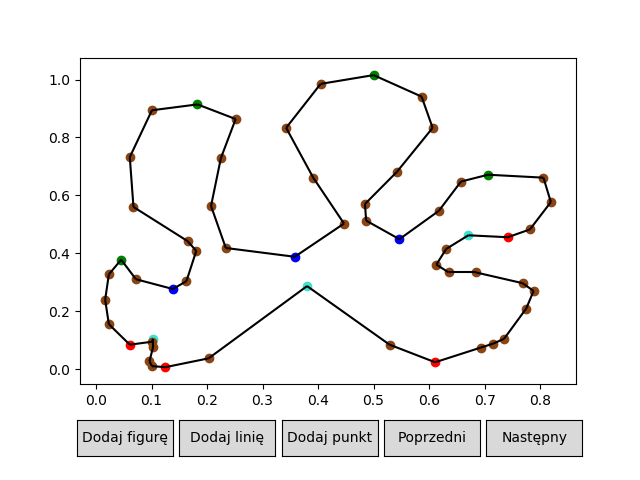

In [7]:
def verticesTypes(polygon):
    n = len(polygon)
    result = {Type.POCZĄTKOWY : [], Type.KOŃCOWY : [], Type.ŁĄCZĄCY : [], Type.DZIELĄCY : [], Type.PRAWIDŁOWY : []}
    for i in range(n - 1):
        if i == 0:
            A = polygon[n - 2]
        else:
            A = polygon[(i - 1) % n]
        B = polygon[i]
        C = polygon[(i + 1) % n]
        if A[1] < B[1] and C[1] < B[1] and orient(A, B, C) == 1:
            result[Type.POCZĄTKOWY].append(i)
        elif A[1] > B[1] and C[1] > B[1] and orient(A, B, C) == 1:
            result[Type.KOŃCOWY].append(i)
        elif A[1] > B[1] and C[1] > B[1] and orient(A, B, C) == -1:
            result[Type.ŁĄCZĄCY].append(i)
        elif A[1] < B[1] and C[1] < B[1] and orient(A, B, C) == -1:
            result[Type.DZIELĄCY].append(i)
        else:
            result[Type.PRAWIDŁOWY].append(i)
    return result

results = [verticesTypes(polygons[i]) for i in range(len(polygons))]
scenes = []
colors = {Type.POCZĄTKOWY : 'green', Type.KOŃCOWY : 'red', Type.ŁĄCZĄCY : 'blue', Type.DZIELĄCY : 'turquoise', Type.PRAWIDŁOWY : 'saddlebrown'}

for i in range(len(polygons)):
    result = results[i]
    polygon = polygons[i]
    scenes.append(Scene([PointsCollection([polygon[result[Type(t)][i]] for i in range(len(result[Type(t)]))], 
                                          color = colors[Type(t)]) for t in range(1, len(Type) + 1)], 
                         [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black')]))

for t in range(1, len(Type) + 1):
    print("%10s"%Type(t).name, " : ", colors[Type(t)], sep = '')
    
plot = Plot(scenes)
plot.draw() 

### Triangulacja wielokąta y-monotonicznego

Wielokąt nie jest y-monotoniczny


<IPython.core.display.Javascript object>


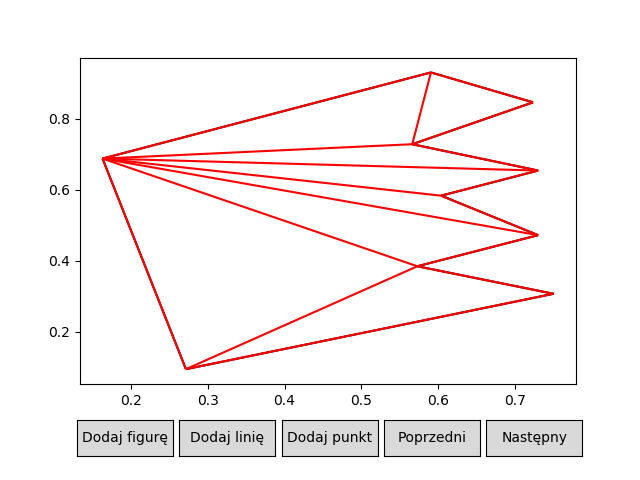

In [8]:
def triangulate(polygon):
    if not isyMonotone(polygon):
        print("Wielokąt nie jest y-monotoniczny")
        return []
    points = findPointsOrder(polygon)
    result = []
    stack = [points[0]]
    
    i = 1
    while i < len(points):
        B = stack[-1]
        C = points[i]
        if C[1] != B[1]:    # Na innych łańcuchach
            for P in stack:
                result.append((C[2], P[2]))
            stack = [B, C]
        else:               # Na tym samym łańcuchu
            A = stack[-2]
            if C[1] == Chain.LEFT and orient(A[0], B[0], C[0]) == 1 or C[1] == Chain.RIGHT and orient(A[0], B[0], C[0]) == -1:
                result.append((A[2], C[2]))
                result.append((B[2], C[2]))
                stack.pop()
                stack.append(C)
            else:
                result.append((B[2], C[2]))
                stack.append(C)
        i += 1
    return result

scenes = []

for i in range(len(polygons)):
    polygon = polygons[i]
    tri = triangulate(polygon)
    scenes.append(Scene([PointsCollection([])], 
                        [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                        LinesCollection([[polygon[tri[i][0]], polygon[tri[i][1]]] for i in range(len(tri))], color = 'red')]))

plot = Plot(scenes)
plot.draw() 

### Wizualizacja triangulacji

<IPython.core.display.Javascript object>


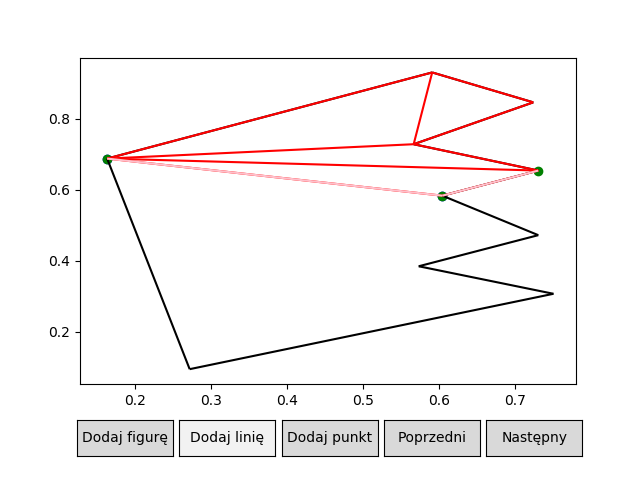

In [9]:
# Wybór wielokąta:
polygon = polygons[0]

scenes = []
scenes.append(Scene([PointsCollection([])], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black')]))

def triangulate(polygon):
    if not isyMonotone(polygon):
        print("Wielokąt nie jest y-monotoniczny")
        return []
    points = findPointsOrder(polygon)
    result = []
    stack = [points[0]]
    
    i = 1
    while i < len(points):
        
        scenes.append(Scene([PointsCollection([stack[i][0] for i in range(len(stack))], color = 'blue')], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red')]))
        
        B = stack[-1]
        C = points[i]
        
        scenes.append(Scene([PointsCollection([stack[i][0] for i in range(len(stack))], color = 'blue'),
                            PointsCollection([B[0], C[0]], color = 'green')], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red')]))
        
        if C[1] != B[1]:    # Na innych łańcuchach
            for P in stack:
                result.append((C[2], P[2]))
                
                scenes.append(Scene([PointsCollection([stack[i][0] for i in range(len(stack))], color = 'blue'),
                            PointsCollection([B[0], C[0]], color = 'green')], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red'),
                    LinesCollection([[C[0], P[0]]], color = 'pink')]))
                
            stack = [B, C]
        else:               # Na tym samym łańcuchu
            A = stack[-2]
            
            scenes.append(Scene([PointsCollection([stack[i][0] for i in range(len(stack))], color = 'blue'),
                            PointsCollection([A[0], B[0], C[0]], color = 'green')], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red')]))
            
            if C[1] == Chain.LEFT and orient(A[0], B[0], C[0]) == 1 or C[1] == Chain.RIGHT and orient(A[0], B[0], C[0]) == -1:
                result.append((A[2], C[2]))
                result.append((B[2], C[2]))
                stack.pop()
                stack.append(C)
                
                scenes.append(Scene([PointsCollection([stack[i][0] for i in range(len(stack))], color = 'blue'),
                            PointsCollection([B[0], C[0], A[0]], color = 'green')], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red'),
                    LinesCollection([[C[0], B[0]], [C[0], A[0]]], color = 'pink')]))
                
            else:
                
                result.append((B[2], C[2]))
                stack.append(C)
                scenes.append(Scene([PointsCollection([stack[i][0] for i in range(len(stack))], color = 'blue'),
                            PointsCollection([B[0], C[0], A[0]], color = 'green')], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red'),
                    LinesCollection([[C[0], B[0]]], color = 'pink')]))
        i += 1
        
    scenes.append(Scene([PointsCollection([])], 
                    [LinesCollection([[polygon[i], polygon[i + 1]] for i in range(len(polygon) - 1)], color = 'black'),
                    LinesCollection([[polygon[result[i][0]], polygon[result[i][1]]] for i in range(len(result))], color = 'red')]))
    
    return result

triangulate(polygon)

plot = Plot(scenes)
plot.draw() 

### Bonus: triangulacja zwracająca trójkąty

<IPython.core.display.Javascript object>


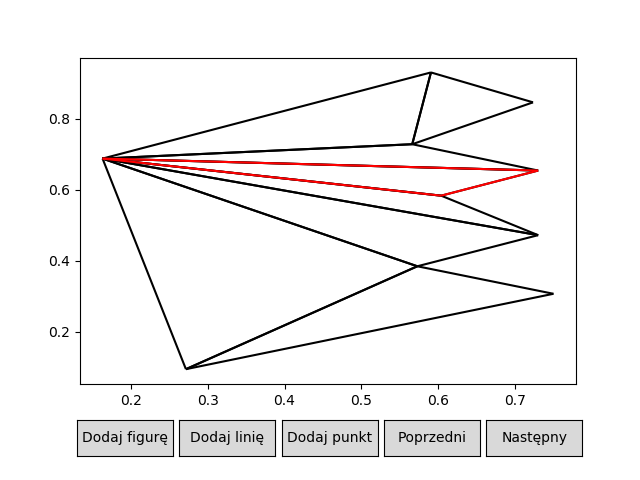

In [10]:
# Wybór wielokąta:
polygon = polygons[0]

def findTriangles(polygon):
    if not isyMonotone(polygon):
        print("Wielokąt nie jest y-monotoniczny")
        return []
    points = findPointsOrder(polygon)
    result = []
    stack = [points[0]]
    
    i = 1
    while i < len(points):
        B = stack[-1]
        C = points[i]
        if C[1] != B[1]:    # Na innych łańcuchach
            for j in range(len(stack) - 2, -1, -1):
                result.append((stack[j][2], stack[j + 1][2], C[2]))
            stack = [B, C]
        else:               # Na tym samym łańcuchu
            A = stack[-2]
            if C[1] == Chain.LEFT and orient(A[0], B[0], C[0]) == 1 or C[1] == Chain.RIGHT and orient(A[0], B[0], C[0]) == -1:
                result.append((A[2], B[2], C[2]))
                stack.pop()
                stack.append(C)
            else:
                stack.append(C)
        i += 1
    return result

triangles = findTriangles(polygon)

scenes = []

scenes.append(Scene([PointsCollection([])], 
                    [LinesCollection([[polygon[triangles[i][j]], polygon[triangles[i][(j + 1) % 3]]] 
                                      for j in range(3) for i in range(len(triangles))], color = 'black')]))

scenes += [Scene([PointsCollection([])], 
                    [LinesCollection([[polygon[triangles[i][j]], polygon[triangles[i][(j + 1) % 3]]] 
                                      for j in range(3) for i in range(len(triangles))], color = 'black'),
                     LinesCollection([[polygon[triangles[i][j]], polygon[triangles[i][(j + 1) % 3]]] 
                                      for j in range(3)], color = 'red')]) for i in range(len(triangles))]

plot = Plot(scenes)
plot.draw() 